# Processing of SCIP features

SCIP features have been computed on EhV data form the first large scale experiment, on files: H1_T7, H1_T8, H1_T9, H2_T7, H2_T8, H2_T9

In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [102]:
from ehv.core import plot_gate_zarr

In [103]:
from umap import UMAP
import time
import math
import tifffile
import pyarrow.parquet as pq
import pyarrow

## SCIP computed features

In [104]:
import os
os.environ["VSC_DATA_VO_USER"]

'/data/gent/vo/000/gvo00070/vsc42015'

In [106]:
df = pandas.concat([
    pq.read_table(p).to_pandas()
    for p in Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202201101434_small/").glob("*.parquet")
], axis=0)

In [107]:
df["meta_sample"] = df["meta_path"].apply(lambda p: Path(p).stem[:-8])

In [108]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

pop_dir = "/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/meta/"
pop_files = list(Path(pop_dir).glob("*.pop"))
pops = {}
for sample in df["meta_sample"].unique():
    pops[sample] = {}
    
    for f in pop_files:
        if f.name.startswith(sample):
            pop_file = f
            with open(pop_file, "r") as fh:
                content = fh.read()
                if len(content) > 0:
                    indices = content[:-2].replace("\n", "").replace(" ", "").strip().split(",")
                    for idx in indices:
                        if ("early" in pop_file.stem) or ("late" in pop_file.stem):
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 3)+1:]
                        else:
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 2)+1:]

In [109]:
def map_to_class(x):
    try:
        s = pops[x.meta_sample]
        return s[x.meta_object_number]
    except:
        return "unknown"

In [110]:
%%time
df["meta_label"] = "unknown"
chunk_size = len(df)//10 + 1
for i in range(0, 10):
    df.iloc[i*chunk_size:(i+1)*chunk_size, df.columns.get_loc("meta_label")] = df.iloc[i*chunk_size:(i+1)*chunk_size].apply(map_to_class, axis=1)
    print(i)

0
1
2
3
4
5
6
7
8
9
CPU times: user 2.59 s, sys: 1.12 s, total: 3.71 s
Wall time: 3.7 s


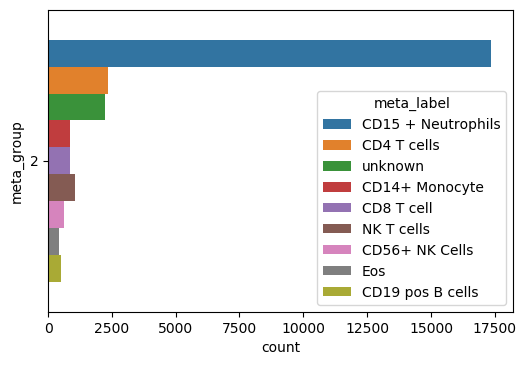

In [111]:
fig, ax = plt.subplots(dpi=100)
seaborn.countplot(ax=ax, data=df, y="meta_group", hue="meta_label")

In [112]:
df["meta_label"].value_counts()

CD15 + Neutrophils    17347
CD4 T cells            2332
unknown                2219
NK T cells             1048
CD14+ Monocyte          880
CD8 T cell              864
CD56+ NK Cells          637
CD19 pos B cells        499
Eos                     447
Name: meta_label, dtype: int64

In [113]:
df.shape

(26273, 2519)

In [114]:
df = df.reset_index(drop=True)

In [116]:
pq.write_table(pyarrow.Table.from_pandas(df), "/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202201101434_small/features.parquet")

In [198]:
df = pq.read_table("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202201101434_small/features.parquet").to_pandas()

## NaN filter

In [199]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(23083, 2519)

In [200]:
df.columns[df.isna().all(axis=0)]

Index(['meta_fix'], dtype='object')

In [201]:
from scip.masking import threshold
from scip.masking import util
from scip.features import texture
import zarr

def compute_glcm(r, bbox_channel_index=0, smooth=0.75):
    z = zarr.open(r.meta_path)
    pixels = z[r.meta_zarr_idx].reshape(z.attrs["shape"][r.meta_zarr_idx])
    pixels = numpy.clip(pixels, a_min=0, a_max=4096)

    m = threshold.get_mask(dict(pixels=pixels), main=True, main_channel=bbox_channel_index, smooth=smooth)
    m = util.get_bounding_box(m, bbox_channel_index=bbox_channel_index)
    m = threshold.get_mask(m, main=False, main_channel=bbox_channel_index, smooth=smooth)
    m = util.remove_regions_touching_border(m, bbox_channel_index=bbox_channel_index)
    m = util.apply(m)

    fig, axes = plt.subplots(2, len(pixels), dpi=150, squeeze=False)
    for i, (a, p) in enumerate(zip(m["mask"], pixels)):
        axes[0, i].imshow(a)
        axes[0, i].set_axis_off()
        axes[1, i].imshow(p)
        axes[1, i].set_axis_off()
        
    m = texture.texture_features(m, 4096)
        
    return m, fig

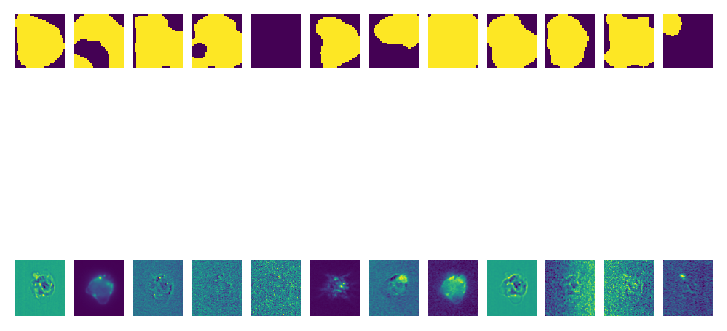

In [202]:
r = df[df.filter(regex="glcm").isna().any(axis=1)].iloc[0]
m, fig = compute_glcm(r, smooth=1.5)

In [203]:
cols = df.filter(regex="glcm").columns[df.filter(regex="glcm").isna().any()]

In [204]:
glcms = pandas.DataFrame(list(map(lambda a: re.match(r"feat_?(?P<comb>combined)?_glcm_(?P<type>[^_]+)_(?P<name>[^_]+)_(?P<dist>[0-9])_(?P<channel>.+)$", a).groupdict(), cols)))

In [205]:
glcms["channel"].unique()

array(['CD15', 'Siglec8', 'CD14', 'CD19', 'SSC', 'CD3', 'CD45', 'BF2',
       'CD4', 'CD56', 'CD8'], dtype=object)

In [206]:
glcms["dist"].value_counts()

3    132
5    132
Name: dist, dtype: int64

In [207]:
glcms.groupby("dist")["type"].value_counts()

dist  type
3     mean    66
      std     66
5     mean    66
      std     66
Name: type, dtype: int64

In [208]:
glcms.groupby("dist")["name"].value_counts()

dist  name         
3     ASM              22
      contrast         22
      correlation      22
      dissimilarity    22
      energy           22
      homogeneity      22
5     ASM              22
      contrast         22
      correlation      22
      dissimilarity    22
      energy           22
      homogeneity      22
Name: name, dtype: int64

In [209]:
glcms.groupby("channel")["name"].value_counts()

channel  name         
BF2      ASM              4
         contrast         4
         correlation      4
         dissimilarity    4
         energy           4
                         ..
Siglec8  contrast         4
         correlation      4
         dissimilarity    4
         energy           4
         homogeneity      4
Name: name, Length: 66, dtype: int64

In [210]:
df["meta_label"].value_counts()

CD15 + Neutrophils    15185
CD4 T cells            2097
unknown                1907
NK T cells              935
CD8 T cell              787
CD14+ Monocyte          735
CD56+ NK Cells          576
CD19 pos B cells        461
Eos                     400
Name: meta_label, dtype: int64

# Number of identified regions per channel 

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


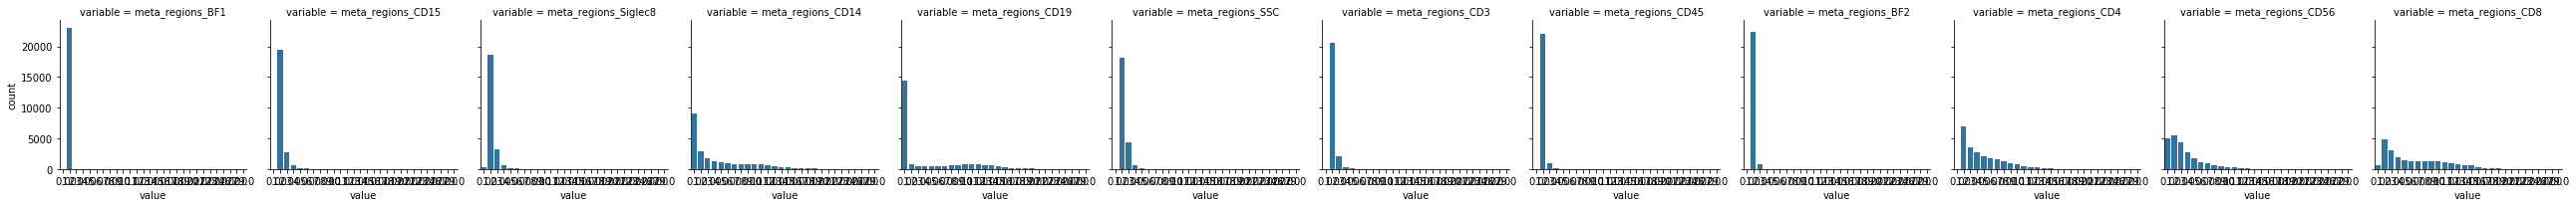

In [211]:
tmp = pandas.melt(df, value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable")
grid.map_dataframe(seaborn.countplot, x="value")

# Detecting multiplets that are missed during segmentation

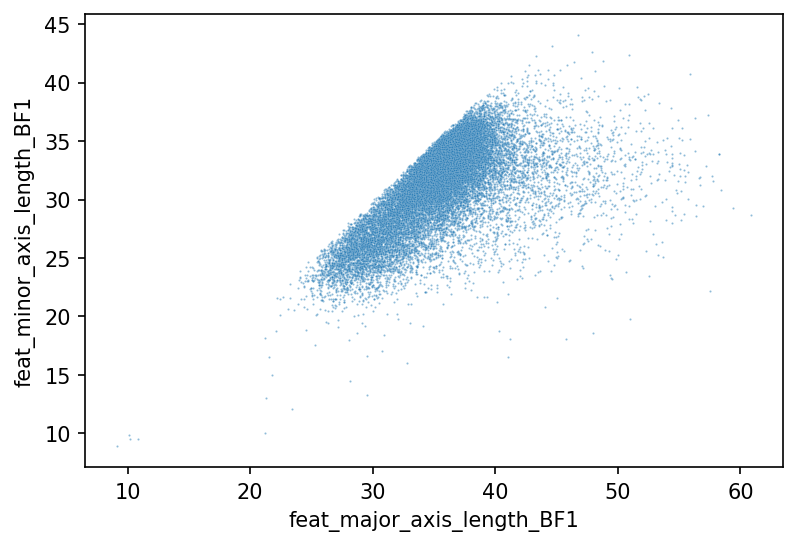

In [212]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_BF1", y="feat_minor_axis_length_BF1", s=1, alpha=0.5)

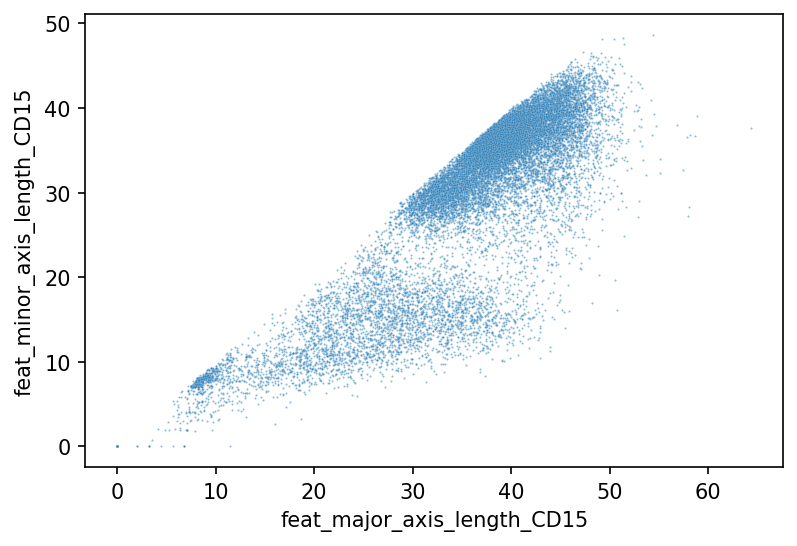

In [213]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_CD15", y="feat_minor_axis_length_CD15", s=1, alpha=0.5)

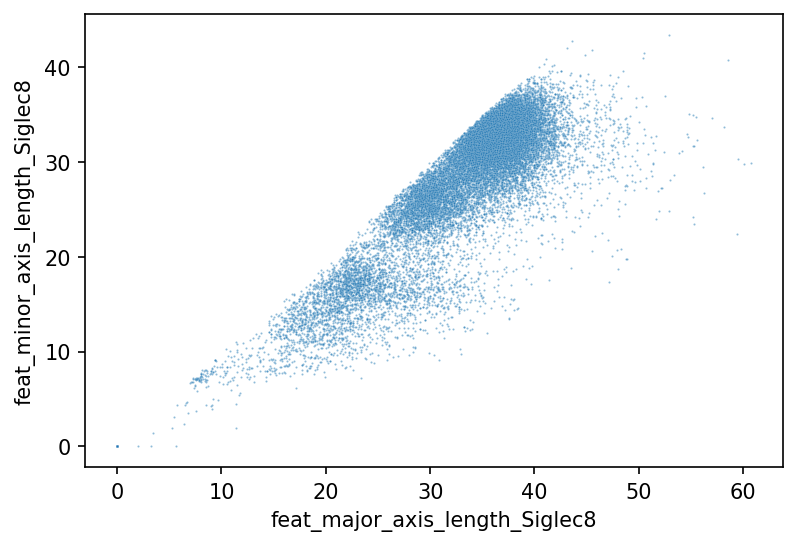

In [214]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_Siglec8", y="feat_minor_axis_length_Siglec8", s=1, alpha=0.5)

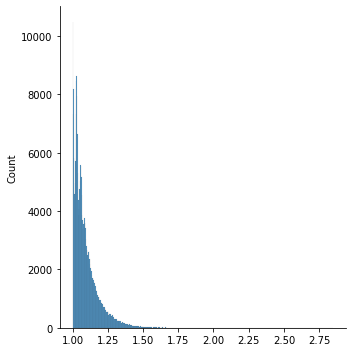

In [35]:
feat_majorminor_ratio = df["feat_major_axis_length_BF1"] / df["feat_minor_axis_length_BF1"]
ax = seaborn.displot(data=feat_majorminor_ratio)

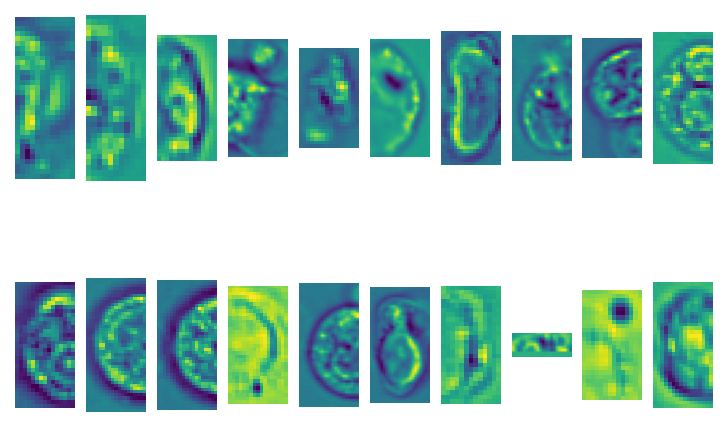

In [36]:
sel1 = feat_majorminor_ratio > 2
plot_gate_zarr(sel1, df)

In [37]:
df = df[~sel1]
df.shape

(257529, 2615)

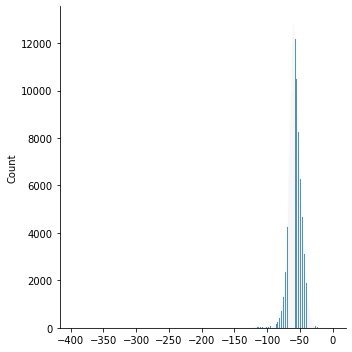

In [38]:
seaborn.displot(data=df["feat_area_BF1"] - df["feat_convex_area_BF1"])

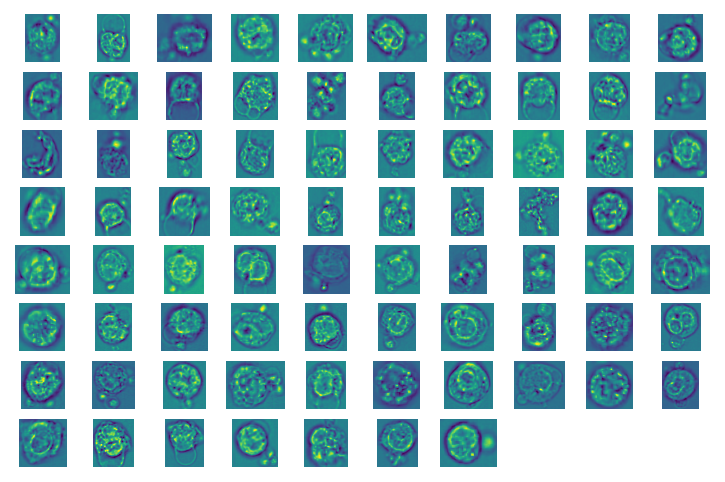

In [39]:
sel1 = (df["feat_area_BF1"] - df["feat_convex_area_BF1"]) < -150
core.plot_gate_zarr(sel1, df)

In [40]:
df = df[~sel1]
df.shape

(257452, 2615)

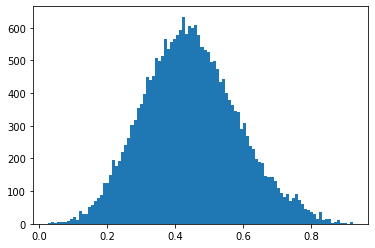

In [215]:
_ = plt.hist(df["feat_eccentricity_BF1"], bins=100)

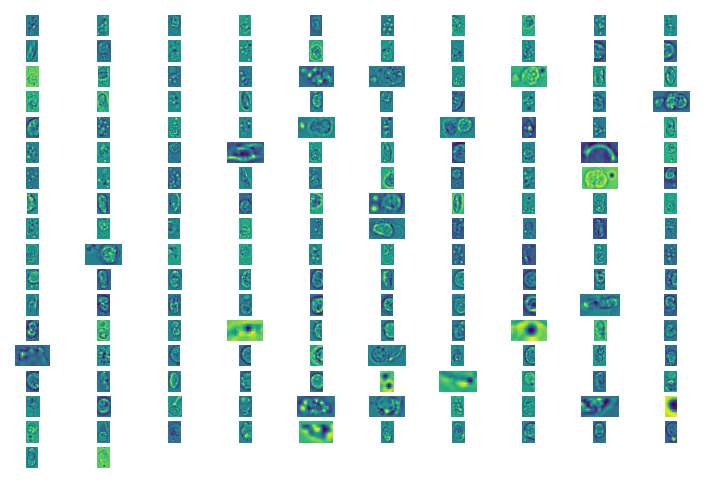

In [42]:
sel1 = df["feat_eccentricity_BF1"] > 0.8
core.plot_gate_zarr(sel1, df)

In [43]:
df = df[~sel1]
df.shape

(257280, 2615)

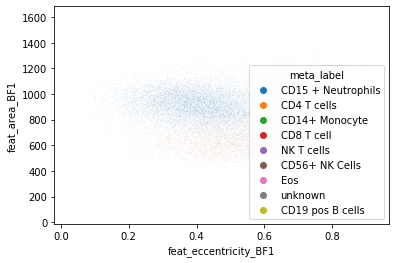

In [216]:
ax = seaborn.scatterplot(data=df, x="feat_eccentricity_BF1", y="feat_area_BF1", s=0.1, alpha=0.5, hue="meta_label")

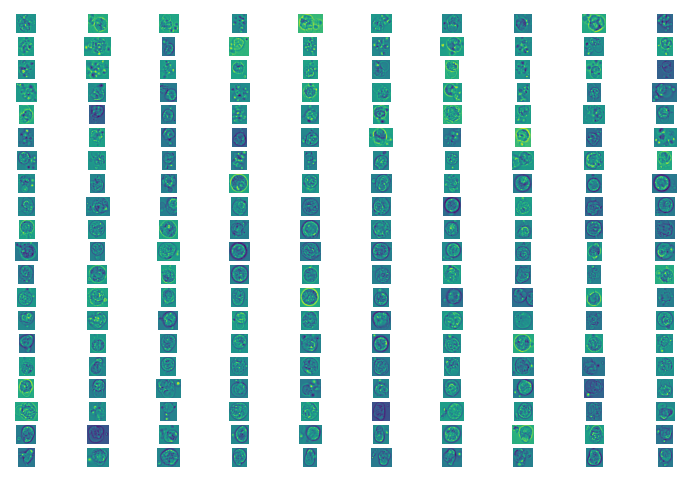

In [45]:
sel1 = df["feat_eccentricity_BF1"] > 0
sel2 = df["feat_area_BF1"] > 2000
core.plot_gate_zarr(sel1 & sel2, df)

In [46]:
df = df[~(sel1 & sel2)]
df.shape

(255900, 2615)

# Noisy events

In [47]:
df["feat_sobel_mean_BF1"].describe()

count    255900.000000
mean          0.288071
std           6.357013
min           0.001241
25%           0.001903
50%           0.002059
75%           0.002270
max         282.177429
Name: feat_sobel_mean_BF1, dtype: float64

<AxesSubplot:>

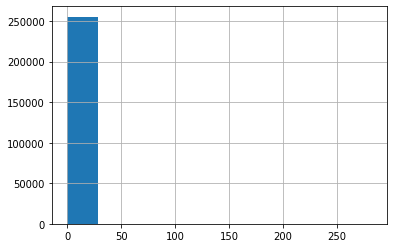

In [48]:
df["feat_sobel_mean_BF1"].hist()

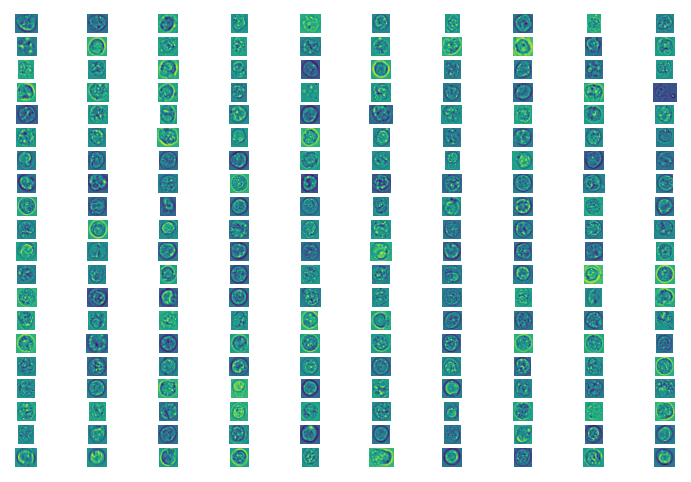

In [49]:
sel1 = df["feat_sobel_mean_BF1"] > 50
core.plot_gate_zarr(sel1, df)

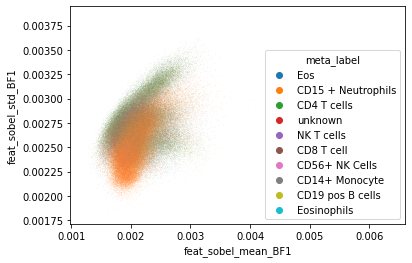

In [50]:
sel1 = df["feat_sobel_mean_BF1"] < 1
sel2 = df["feat_sobel_std_BF1"] < 1
ax = seaborn.scatterplot(data=df[sel1 & sel2], x="feat_sobel_mean_BF1", y="feat_sobel_std_BF1", s=0.1, alpha=0.5, hue="meta_label")

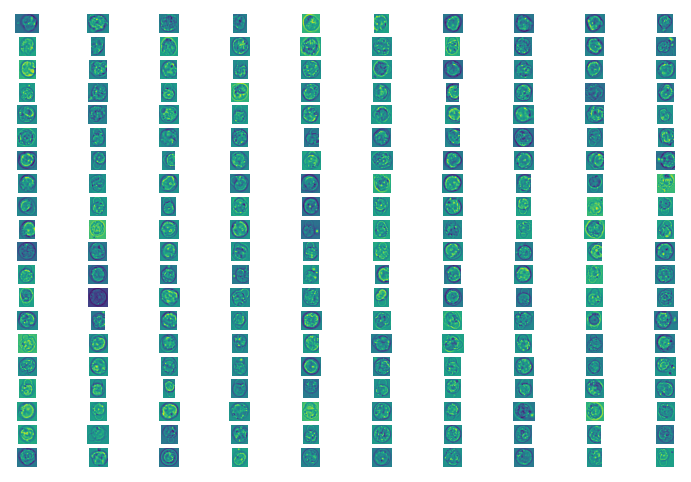

In [51]:
sel1 = df["feat_sobel_mean_BF1"] < 0.0015
core.plot_gate_zarr(sel1, df)

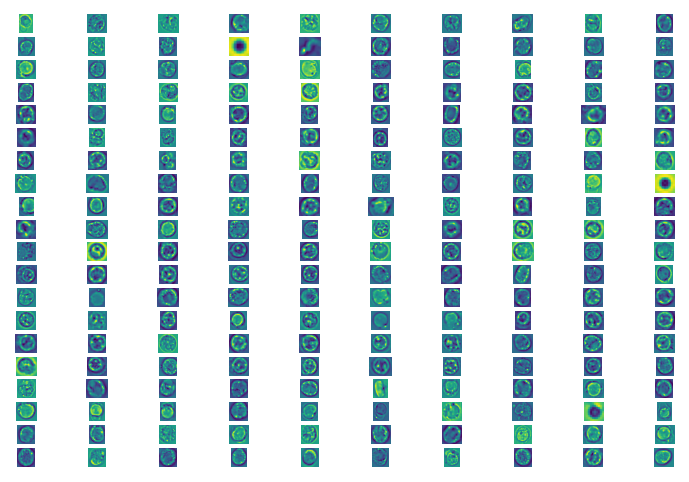

In [52]:
sel1 = df["feat_sobel_mean_BF1"] > 0.003
core.plot_gate_zarr(sel1, df)

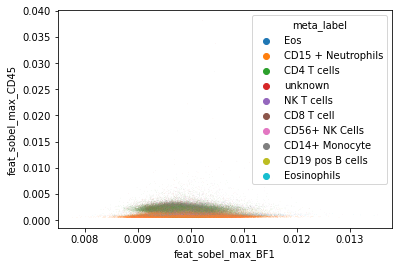

In [53]:
sel1 = df["feat_sobel_max_BF1"] < 1
sel2 = df["feat_sobel_max_CD45"] < 1
ax = seaborn.scatterplot(data=df[sel1 & sel2], x="feat_sobel_max_BF1", y="feat_sobel_max_CD45", s=0.1, alpha=0.5, hue="meta_label")

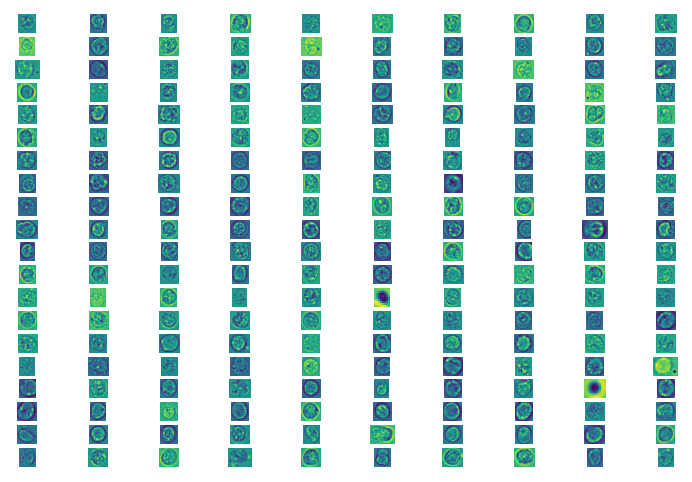

In [54]:
sel1 = df["feat_sobel_max_BF1"] > 0.012
core.plot_gate_zarr(sel1, df)

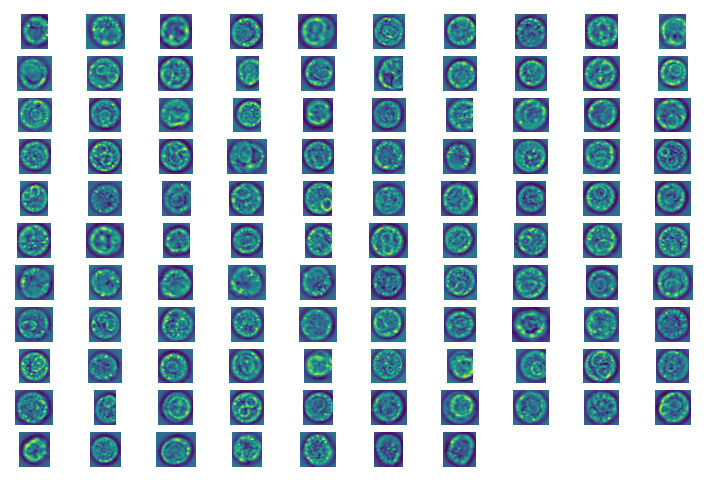

In [55]:
sel1 = df["feat_sobel_max_BF1"] < 0.0085
core.plot_gate_zarr(sel1, df)

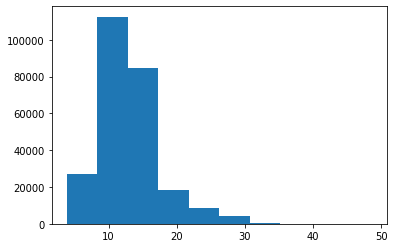

In [56]:
_ = plt.hist(df["feat_glcm_mean_contrast_5_BF1"])

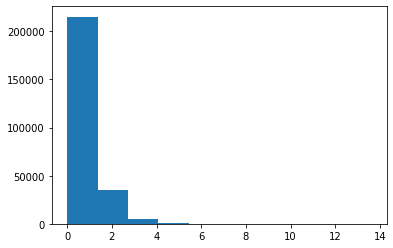

In [57]:
_ = plt.hist(df["feat_glcm_std_contrast_5_BF1"])

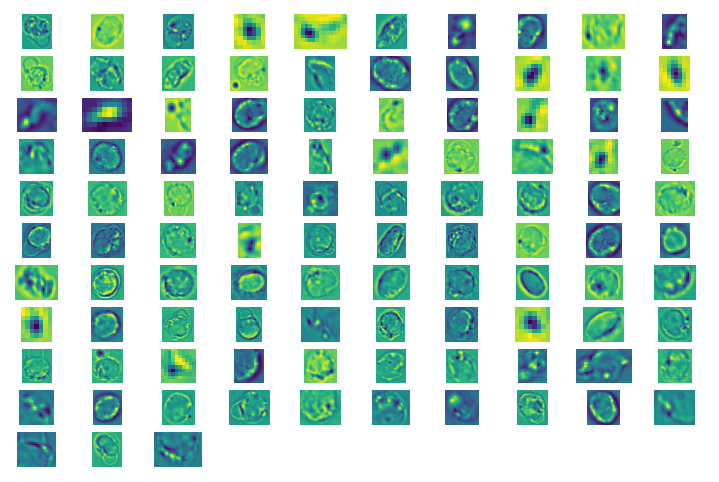

In [58]:
sel1 = df["feat_glcm_std_contrast_5_BF1"] > 6
core.plot_gate_zarr(sel1, df)

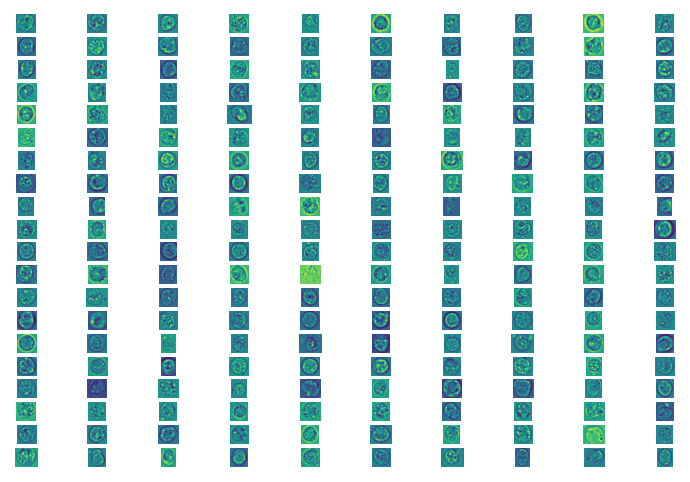

In [59]:
sel1 = df["feat_glcm_std_contrast_5_BF1"] < 1
core.plot_gate_zarr(sel1, df)

In [60]:
df["meta_label"].value_counts()

CD15 + Neutrophils    153596
CD4 T cells            37300
unknown                16769
CD8 T cell             16214
CD19 pos B cells        9753
CD56+ NK Cells          7268
NK T cells              5223
CD14+ Monocyte          5223
Eosinophils             3435
Eos                     1119
Name: meta_label, dtype: int64

# Distributions

In [63]:
var_s = df.filter(regex="feat").var()

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/pandas/core/nanops.py:933: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


In [67]:
var_s.isna().sum()

0

# Feature correlation

In [68]:
%%time
correlation = df.sample(n=10000).filter(regex="feat.*").corr()

CPU times: user 2min 36s, sys: 113 ms, total: 2min 36s
Wall time: 2min 36s


In [75]:
correlation.isna()

,feat_area_BF1,feat_convex_area_BF1,feat_eccentricity_BF1,feat_equivalent_diameter_BF1,feat_euler_number_BF1,feat_feret_diameter_max_BF1,feat_filled_area_BF1,feat_major_axis_length_BF1,feat_minor_axis_length_BF1,feat_orientation_BF1,...,feat_combined_glcm_std_correlation_3_CD8,feat_combined_glcm_std_correlation_5_CD8,feat_combined_glcm_mean_ASM_3_CD8,feat_combined_glcm_mean_ASM_5_CD8,feat_combined_glcm_std_ASM_3_CD8,feat_combined_glcm_std_ASM_5_CD8,feat_combined_sobel_mean_CD8,feat_combined_sobel_std_CD8,feat_combined_sobel_max_CD8,feat_combined_sobel_min_CD8
feat_area_BF1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
feat_convex_area_BF1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
feat_eccentricity_BF1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
feat_equivalent_diameter_BF1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
feat_euler_number_BF1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feat_combined_glcm_std_ASM_5_CD8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
feat_combined_sobel_mean_CD8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
feat_combined_sobel_std_CD8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
feat_combined_sobel_max_CD8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Overall feature correlation

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

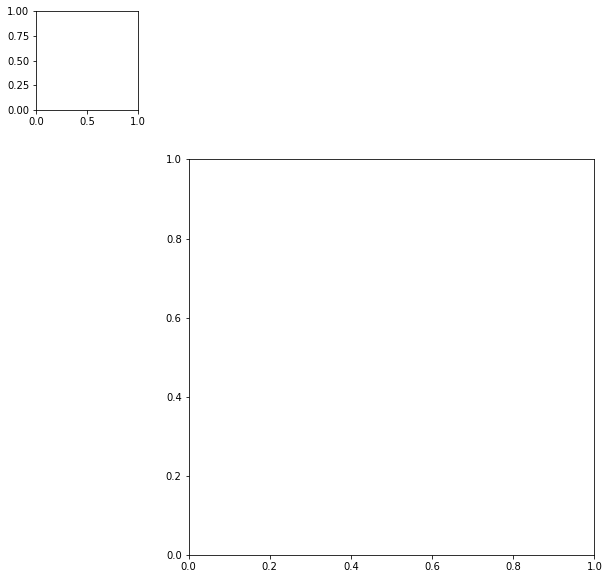

In [69]:
seaborn.clustermap(correlation)

In [157]:
def get_correlated_features(df, cutoff=0.85):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > cutoff:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [158]:
correlated_features = get_correlated_features(df.filter(regex="feat"), cutoff=0.7)
correlation2 = df.filter(regex="feat").drop(columns=correlated_features).corr()

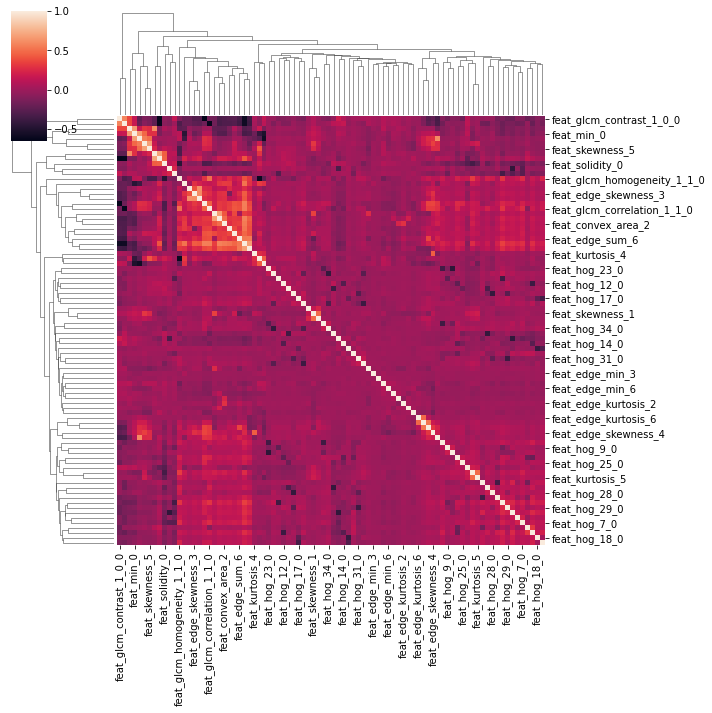

In [159]:
seaborn.clustermap(correlation2)

In [160]:
len(correlated_features)

153

In [161]:
df = df.drop(columns=correlated_features)

In [162]:
df.shape

(58440, 112)

In [163]:
len(df.index.values)

58440

# Export

In [218]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202201101434_small/index.npy", df.index.values)

In [219]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202201101434_small/columns.npy", df.columns.values)